In [1]:
import os
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# Load data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [3]:
# Check dimensions of image
x_train[0].shape

(28, 28)

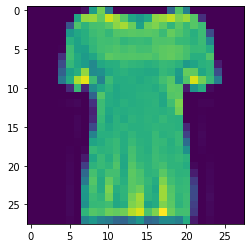

In [4]:
# View a sample image
plt.imshow(x_train[10])

In [5]:
##################################################
# Explore training data and labels
##################################################

In [6]:
x_train

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [7]:
x_train[10].max()

255

In [8]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [3]:
print("Train data shape:{}".format(x_train.shape))
print("Test data shape:{}".format(x_test.shape))

Train data shape:(60000, 28, 28)
Test data shape:(10000, 28, 28)


In [4]:
print("Number of classes training labels:{}".format(len(pd.unique(y_train))))
print("Unique values in training labels:{}".format(pd.unique(y_train)))

Number of classes training labels:10
Unique values in training labels:[9 0 3 2 7 5 1 6 4 8]


In [5]:
# Normalize image pixel values
x_train = x_train / 255
x_test = x_test / 255

In [6]:
# Prepare one-hot encoded y-values
y_train_cat = keras.utils.to_categorical(y=y_train, num_classes=10)
y_test_cat = keras.utils.to_categorical(y=y_test, num_classes=10)

In [7]:
# Reshaping data to batch_size, width, height, color_channel
x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)

In [8]:
# Prepare GPU
def prep_devices():
    phy_gpus = tf.config.list_physical_devices(device_type='GPU')

    for gpu in phy_gpus:
        tf.config.experimental.set_memory_growth(device=gpu, enable=True)

    log_gpus = tf.config.list_logical_devices(device_type='GPU')
    phy_cpus = tf.config.list_physical_devices(device_type='CPU')
    log_cpus = tf.config.list_logical_devices(device_type='CPU')

    print("Physical GPUs: {}\tLogical GPUs: {}\nPhysical CPUs: {}\tLogical CPUs: {}".format(len(phy_gpus),
                                                                                             len(log_gpus),
                                                                                             len(phy_cpus),
                                                                                             len(log_cpus)))

In [9]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
prep_devices()

Physical GPUs: 1	Logical GPUs: 1
Physical CPUs: 1	Logical CPUs: 1


In [10]:
# Build model
def model_func(clear_session=True):
    if clear_session:
        backend.clear_session()
            
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(28, 28, 1), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.5))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    model.summary()
    
    return model

In [15]:
# Fit model
model = model_func()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
model.fit(x=x_train, y=y_train_cat, epochs=50, validation_split=0.1, batch_size=500, callbacks=[early_stop])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                5

In [16]:
# Model evaluation
metrics = pd.DataFrame(model.history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,1.223114,0.551667,0.669974,0.748667
1,0.740286,0.728648,0.540561,0.793833
2,0.642424,0.761704,0.489355,0.815167
3,0.589581,0.782481,0.451896,0.830333
4,0.554326,0.796426,0.425706,0.842833
5,0.530021,0.806648,0.407183,0.849500
6,0.507544,0.815944,0.392258,0.856000
7,0.485335,0.826056,0.372555,0.859167
8,0.472640,0.828056,0.364288,0.864000
9,0.463641,0.831889,0.357879,0.866500


<AxesSubplot:>

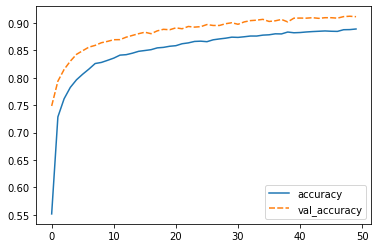

In [17]:
# Evaluate graphically
metrics = pd.DataFrame(model.history.history)
sns.lineplot(data=metrics[['accuracy', 'val_accuracy']])

In [18]:
# Compute predicted classes and model performance metrics
y_pred = np.argmax(model.predict(x_test), axis=-1)

print(classification_report(y_true=y_test, y_pred=y_pred))
print("\n")
print(confusion_matrix(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.86      0.86      0.86      1000
           3       0.89      0.92      0.90      1000
           4       0.84      0.86      0.85      1000
           5       0.98      0.98      0.98      1000
           6       0.72      0.68      0.70      1000
           7       0.95      0.96      0.96      1000
           8       0.97      0.98      0.98      1000
           9       0.97      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



[[848   0  18  23   3   1 100   0   7   0]
 [  0 975   0  18   3   0   2   0   2   0]
 [ 14   0 861  10  53   0  62   0   0   0]
 [ 10   3  10 915  25   0  35   0   2   0]
 [  0   1  39  32 856   0  69   0   3   0]
 [  0   0   0   0   0 98